In [1]:
# import functions
import idaes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# import HFC_IL mixture properties
from HFC125_emimTf2N_PR import configuration

# parmest (binary_param2)
from binary_param2 import binary_params_peng
# from HFC32_emimTf2N_PR import configuration
from HFC125_emimTf2N_PR import configuration

In [2]:
#need to make excel csv for 125
data = pd.read_csv('R125_emimTf2N.csv')
data_283= data[0:9]
data_298 = data[9:18]
data_323 = data[18:27]
data_348 = data[27:36]

# Parmest to get Kappas

In [3]:
# from HFC32_emimTf2N_PR import configuration
from HFC125_emimTf2N_PR import configuration
binary_params_peng('R125_emimTf2N.csv', configuration, 'R125', 'emimTf2N', "x_R125", "x_emimTf2N", 
    init_temp = 298.15, init_press = 250200, init_x_c1 = 0.218, init_x_c2 =0.782 ,
    init_kappa_2_1 = -0.20, init_kappa_1_2 = -0.056, eps = 0.1, scaling_fac = 1e-9)

2021-03-23 16:05:30 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-23 16:05:30 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-23 16:05:30 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-23 16:05:30 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-23 16:05:30 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-23 16:05:31 [INFO] idaes.init.fs.state_

2021-03-23 16:05:36 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-23 16:05:36 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-23 16:05:36 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-23 16:05:37 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-23 16:05:37 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-23 16:05:37 [INFO] idaes.init.fs.state_

  29  1.6908169e-01 1.00e-07 2.56e+01  -8.6 2.52e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.6908168e-01 1.01e-11 1.13e-12  -8.6 7.16e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   1.6908168135087726e-01    1.6908168135087726e-01
Dual infeasibility......:   1.1297575401370579e-12    1.1297575401370579e-12
Constraint violation....:   1.0143885731395130e-11    1.0143885731395130e-11
Complementarity.........:   2.5060460180593252e-09    2.5060460180593252e-09
Overall NLP error.......:   2.5060460180593252e-09    2.5060460180593252e-09


Number of objective function evaluations             = 72
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 72
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

# Create Flash Model

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

2021-03-23 16:05:42 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The initial DOF is 7


In [5]:
# # make function general
# def calc_outlet_xP(data,HFC,IL, k21,k12,verbose=False):
#     '''Inputs
#             Data - csv file for x,T,P data HFC-IL
#             HFC  - string with name of HFC (i.e.'R125')
#             IL   - string with name of IL (i.e. 'emimTf2N')
#             k21  - binary parameter IL-HFC
#             k12  - binary parameter HFC-IL
            
#             '''
#     # create zeros arrays to be filled with x1 and P1
#     HFC_x = np.zeros((len(data)))
#     P = np.zeros((len(data)))
    
#     # model constraints
#     m.fs.liq = Param(mutable=True,default=0.040)
#     m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emim_Tf2N"] == m.fs.liq)

#     for i in range(len(data)):
#         m.fs.liq = data['x_'+IL].iloc[i]
#         m.fs.F101.inlet.flow_mol.fix(1) 
#         m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
#         m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
#         m.fs.F101.inlet.mole_frac_comp[0, HFC].fix(float(data['x_'+HFC].iloc[i])+0.1)
#         m.fs.F101.inlet.mole_frac_comp[0, IL].fix(float(1-(data['x_'+HFC].iloc[i]+0.1)))
#         m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
#         m.fs.properties.PR_kappa[IL, HFC].fix(k21) # (-0.20093)
#         m.fs.properties.PR_kappa[HFC, IL].fix(k12) # (-0.05619)

#         if verbose:
#             DOF_final = degrees_of_freedom(m)
#             print("The final DOF is {0}".format(DOF_final))

#         # solver
#         m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
#         solver = SolverFactory('ipopt')
#         solver.options = {'tol': 1e-6}
#         status = solver.solve(m, tee = False)
#     #     m.fs.F101.report()
#         if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
#             HFC_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,HFC]) 
#             P[i] = value(m.fs.F101.vap_outlet.pressure[0])
#         else:
#             print('Infeasible.')
#     return (HFC_x,P)

In [6]:
def calc_outlet_xP(data,k21,k12,verbose=False):
    # create zeros arrays to be filled with x1 and P1
    R125_x = np.zeros((len(data)))
    P = np.zeros((len(data)))
    
    # model constraints
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data["x_R125"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R125"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['emimTf2N', 'R125'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R125', 'emimTf2N'].fix(k12) # (-0.05619)

        if verbose:
            DOF_final = degrees_of_freedom(m)
            print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible.')
    return(R125_x,P)

### AG Check Params

In [7]:
# AG Check
    # K21= -0.015
    # K12= -0.034

In [8]:
R125_x,P= calc_outlet_xP(data,-0.034795087689,-0.015923346845, verbose=True)

The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0


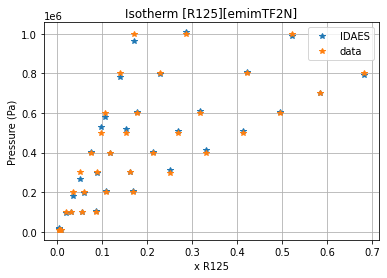

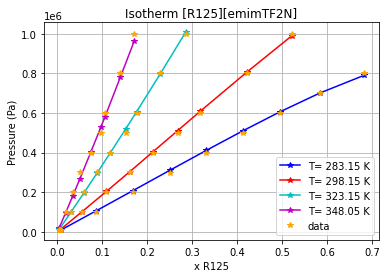

In [9]:
# plot with data straight out of the function

plt.plot(R125_x,P,"*",label="IDAES")  
plt.plot(data["x_R125"],data["pressure"],"*",label="data")  
plt.title('Isotherm [R125][emimTF2N]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R125')
plt.grid(True)
plt.legend()
plt.show()


# plots with data - model as lines --- need to make this into a function that splits up the T's 
plt.plot(R125_x[0:9],P[0:9],"b*-",label="T= 283.15 K")  
plt.plot(R125_x[9:18],P[9:18],"r*-",label="T= 298.15 K") 
plt.plot(R125_x[18:27],P[18:27],"c*-",label="T= 323.15 K") 
plt.plot(R125_x[27:],P[27:],"m*-",label="T= 348.05 K")
plt.plot(data["x_R125"],data["pressure"],"*",color='orange',label="data") 
plt.title('Isotherm [R125][emimTF2N]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R125')
plt.grid(True)
plt.legend()
plt.show()

## Sensitivity Analysis

In [15]:
# plot function to see if it works - works when i store value, plot, store value 2, plot 2 etc
def plot_sens_analysis(data,kappa21,kappa12,T_label):
    x1,P1= calc_outlet_xP(data, kappa21[0],kappa12[0])
    plt.plot(x1,P1,"b+",label="K21= -0.013 ,K12= -0.033")
    x2,P2= calc_outlet_xP(data,kappa21[0],kappa12[1])
    plt.plot(x2,P2,"g+",label="K21= -0.013, K12=-0.035")
    x3,P3= calc_outlet_xP(data,kappa21[0],kappa12[2])
    plt.plot(x3,P3,"m+",label="K21= -0.013, K12=-0.037")
    x4,P4= calc_outlet_xP(data,kappa21[0],kappa12[3])
    plt.plot(x4,P4,"c+",label="K21= -0.013, K12=-0.039")
    x5,P5= calc_outlet_xP(data,kappa21[1],kappa12[0])
    plt.plot(x5,P5,"b*",label="K21= -0.015, K12=-0.033")
    x6,P6= calc_outlet_xP(data,kappa21[1],kappa12[1])
    plt.plot(x6,P6,"g-*",label="K21= -0.015, K12=-0.035")
    x7,P7= calc_outlet_xP(data,kappa21[1],kappa12[2])
    plt.plot(x7,P7,"m*",label="K21= -0.015, K12=-0.037")
    x8,P8= calc_outlet_xP(data,kappa21[1],kappa12[3])
    plt.plot(x8,P8,"c*",label="K21= -0.015, K12=-0.039")
    x9,P9= calc_outlet_xP(data,kappa21[2],kappa12[0])
    plt.plot(x9,P9,"b^",label="K21= -0.017, K12=-0.033")
    x10,P10= calc_outlet_xP(data,kappa21[2],kappa12[1])
    plt.plot(x10,P10,"g^",label="K21= -0.017, K12=-0.035")
    x11,P11= calc_outlet_xP(data,kappa21[2],kappa12[2])
    plt.plot(x11,P11,"m^",label="K21= -0.017, K12=-0.037")
    x12,P12= calc_outlet_xP(data,kappa21[2],kappa12[3])
    plt.plot(x12,P12,"c^",label="K21= -0.017, K12=-0.039")
    # plot data and configuration
    plt.plot(data["x_R125"],data["pressure"],"r.",label="data")  
    plt.title('Isotherm [R125][emimTF2N] at '+ T_label)
    plt.ylabel('Pressure (Pa)')
    plt.xlabel('x R32')
    plt.ylim(0,900000)
    plt.grid(True)
    plt.legend()
    plt.show()

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

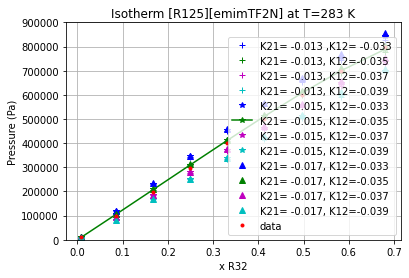

In [16]:
# AG Check
    # K21= -0.015
    # K12= -0.034
data_298 = data[9:18]
# anlaysis
kappa21= np.array([-0.025,-0.035,-0.045,-0.055])
kappa12= np.array([-0.006,-0.016,-0.026,-0.036])
plot_sens_analysis(data_283,kappa21,kappa12, "T=283 K")